In [86]:
import pandas as pd
import matplotlib.pyplot as plt

In [87]:
df = pd.read_csv("../../data/01122022_Fran_a_tls_report_TOI-540.csv")

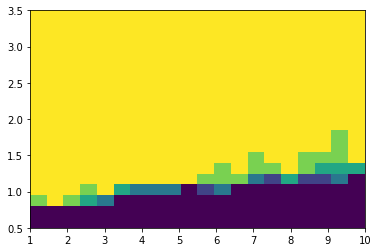

In [88]:
from scipy.stats import binned_statistic_2d

bins=(20, 20)
radius, period, found = df[["radius", "period", "found"]].values.T.astype(float)
stats = binned_statistic_2d(period, radius, found, bins=bins)
im = plt.imshow(
    stats.statistic.T, 
    origin="lower",
    extent=(
        stats.x_edge.min(), 
        stats.x_edge.max(), 
        stats.y_edge.min(), 
        stats.y_edge.max()
    ),
    aspect="auto",
)

In [89]:
import astropy.constants as c
import astropy.units as u
import numpy as np

# TOI-540
# https://exofop.ipac.caltech.edu/tess/target.php?id=200322593
Rs = 0.178 * u.R_sun
Ms = 0.157 * u.M_sun
w = 0.002524194
duration = 50.801648 * u.day # 2 sectors
dt = 2 * u.minute
sigma, omega = 0.01678591968956381, 8.87037925719471*(1/u.day)

def _taudelta_to_RP(tau_v, delta_v):
    depth = 2*sigma/delta_v
    Rp = np.sqrt(depth)*Rs
    
    T = (np.pi/(omega*tau_v)).to(u.hour)
    a = (c.G * Ms * T**2) / (4*(Rs**2))

    P = 2*np.pi*a**(3/2) / np.sqrt(c.G * Ms)
    P = P.decompose().to(u.day)
    
    n_tr = (duration/P).decompose()
    snr = (depth/w)*np.sqrt(n_tr*(T/dt).decompose())
    
    return Rp.to(u.R_earth).value, P.decompose().to(u.day).value, snr

taudelta_to_RP = np.vectorize(_taudelta_to_RP)
    
def _snr(Rp, P):
    P = P * u.day
    Rp = Rp * u.R_earth
    
    depth = (Rp/Rs)**2
    a = ((c.G*Ms*(P**2))/(4*(np.pi**2)))**(1/3)
    T = (P*Rs)/(np.pi*a)    
    n_tr = (duration/P)
    return (depth/w)*np.sqrt(n_tr*(T/dt))

SNR = np.vectorize(_snr)

def _RP_to_taudelta(Rp, P):
    P = P * u.day
    Rp = Rp * u.R_earth
    
    depth = (Rp/Rs)**2
    delta_v = (2*sigma/depth).decompose()
    a = ((c.G*Ms*(P**2))/(4*(np.pi**2)))**(1/3)
    T = (P*Rs)/(np.pi*a)
    
    tau_v = (np.pi/(omega*T))
    
    n_tr = (duration/P)
    snr = (depth/w)*np.sqrt(n_tr*(T/dt))
    
    return float(tau_v.decompose()), float(delta_v.decompose()), float(snr.decompose())

RP_to_taudelta = np.vectorize(_RP_to_taudelta, )

# tests
# -----
A = (1, 1)
*a, _ = _taudelta_to_RP(*A)
*B, _ = _RP_to_taudelta(*a)
assert np.allclose(A, B)

A = (radius[0], period[0])
*a, _ = _RP_to_taudelta(*A)
*B, _ = _taudelta_to_RP(*a)
assert np.allclose(A, B)

print("all close")

all close


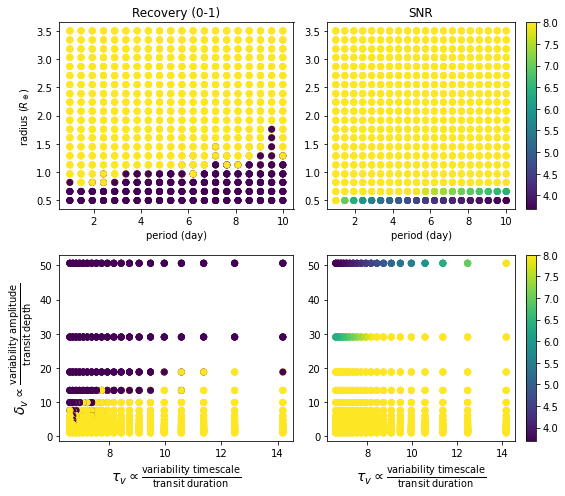

In [103]:
radius, period, found = df[["radius", "period", "found"]].values.T.astype(float)
tau_v, delta_v, _ = RP_to_taudelta(radius, period)

plt.figure(figsize=(8, 7))
plt.subplot(221)
plt.scatter(period, radius, c=found)
plt.xlabel("period (day)")
plt.ylabel(r"radius $(R_\oplus)$")
plt.title("Recovery (0-1)")
plt.subplot(222)
plt.scatter(period, radius, c=SNR(radius, period), vmax=8)
plt.xlabel("period (day)")
plt.title("SNR")
plt.colorbar()
plt.tight_layout()
plt.subplot(223)
plt.scatter(tau_v, delta_v, c=found)
plt.ylabel(r"$\delta_v \propto \frac{\mathrm{variability\; amplitude}}{\mathrm{transit\;depth}}$", fontsize=14)
plt.xlabel(r"$\tau_v \propto \frac{\mathrm{variability\; timescale}}{\mathrm{transit\;duration}}$", fontsize=14)
plt.subplot(224)
plt.scatter(tau_v, delta_v, c=SNR(radius, period), vmax=8)
plt.xlabel(r"$\tau_v \propto \frac{\mathrm{variability\; timescale}}{\mathrm{transit\;duration}}$", fontsize=14)
plt.colorbar()
plt.tight_layout()
plt.savefig("issue_paramspace_IR.pdf")

In [105]:
n = 20
radius, period, found = df[["radius", "period", "found"]].values.T.astype(float)

# random
if False:
    tau_v = np.random.uniform(5., 20, size=n*n)
    delta_v = np.random.uniform(.5, 30, size=n*n)

# grid
else:
    tau_v = []
    delta_v = []
    
    tmin, vmin, _ = RP_to_taudelta(max(radius), max(period)) 
    tmax, vmax, _ = RP_to_taudelta(min(radius), min(period)) 

    print(tmin, vmin)

    tauv = np.linspace(tmin, tmax, n)
    deltav = np.linspace(vmin, vmax, n)

    for t in tauv:
        for d in deltav:
            tau_v.append(t)
            delta_v.append(d)

6.586811411776186 1.0330953600997221


In [106]:
radius, period, snr = taudelta_to_RP(np.array(tau_v), np.array(delta_v))

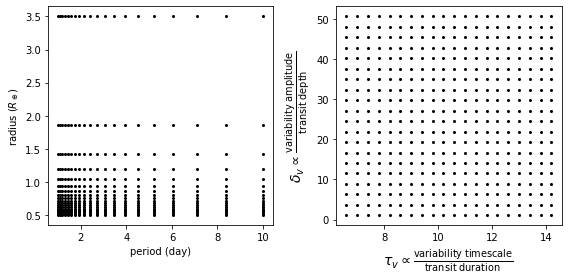

In [158]:
from matplotlib import patches

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(period, radius, s=4, c="k")
plt.xlabel("period (day)")
plt.ylabel(r"radius $(R_\oplus)$")
plt.subplot(122)
plt.scatter(tau_v, delta_v, s=4, c="k")
plt.ylabel(r"$\delta_v \propto \frac{\mathrm{variability\; amplitude}}{\mathrm{transit\;depth}}$", fontsize=14)
plt.xlabel(r"$\tau_v \propto \frac{\mathrm{variability\; timescale}}{\mathrm{transit\;duration}}$", fontsize=14)
#plt.subplot(132)
#plt.axis("off")
#plt.gca().add_artist(a)
plt.tight_layout()

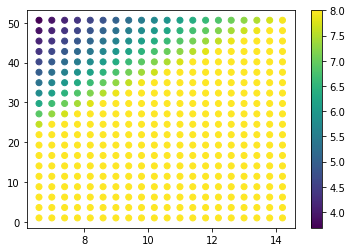

In [160]:
plt.scatter(tau_v, delta_v, c=SNR(radius, period), vmax=8)
plt.colorbar()